In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd
from scipy.stats import sem

In [40]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

([], <a list of 0 Text xticklabel objects>)

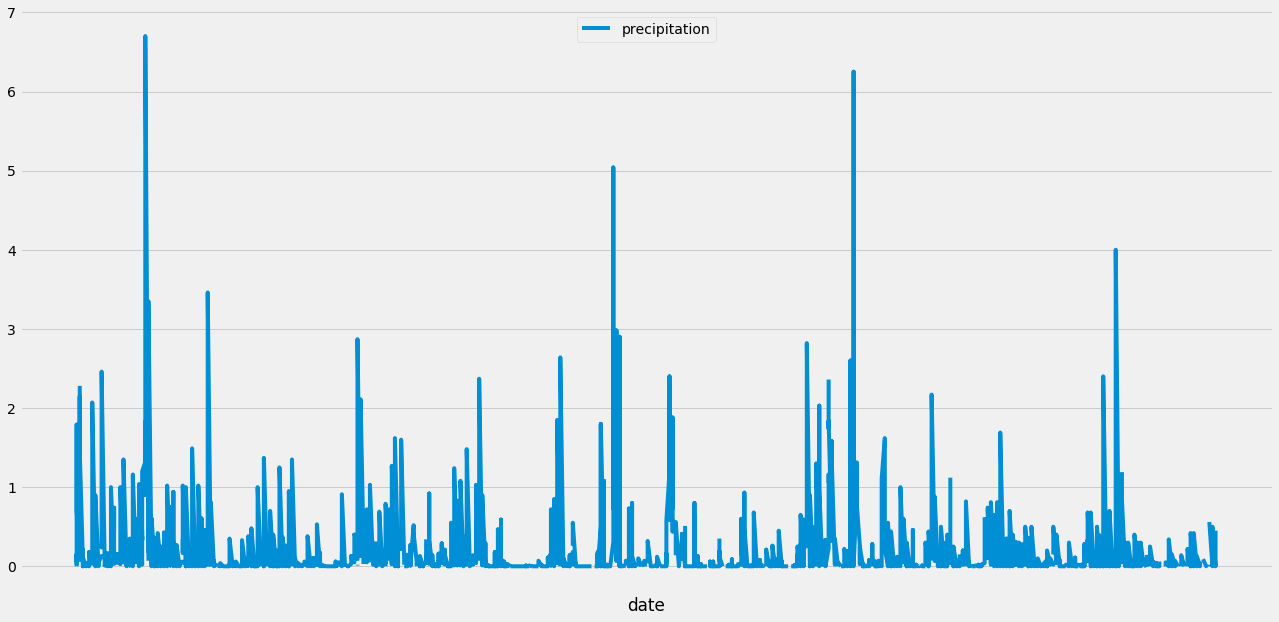

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date = end_date[0]
start_date = dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=366) 

# Perform a query to retrieve the data and precipitation scores
precp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >=start_date).\
    filter(Measurement.date <=end_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precp_data, columns=['date', 'precipitation'])
precipitation_data.set_index('date',inplace=True)

# Sort the dataframe by date
precipitation_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,10))
plt.plot(precipitation_data.index, precipitation_data.precipitation)
plt.legend(loc='upper center')
plt.xlabel('date')
plt.xticks([])




In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Measurement.station).\
    group_by(Measurement.station).count()
count

9

In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

max_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

max_station = max_station[0]

temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                          filter(Measurement.station==max_station).all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

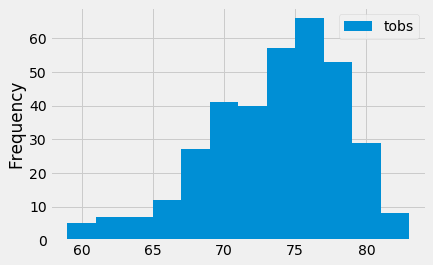

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

max_precp = session.query(Measurement.tobs).\
    filter(Measurement.date >=start_date).\
    filter(Measurement.date <=end_date).\
    filter(Measurement.station==max_station).all()

temp_data = pd.DataFrame(max_precp)
plt.hist(temp_data.tobs, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend(loc='best')


In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-08-07'
trip_end = '2017-08-17'
temps = calc_temps(trip_start, trip_end)
temps_df = pd.DataFrame(temps, columns =('min','avg','max'))
avg_graph = temps_df['avg']


C:\Users\Avasant\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


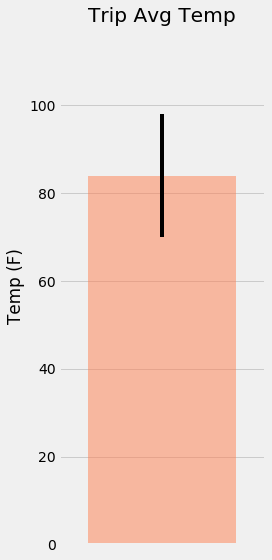

In [55]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = temps_df['max'] - temps_df['min'] 

bar = ax.bar(xpos, temps_df['max'], yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels='a', title='Trip Avg Temp', ylabel='Temp (F)')
ax.margins(.2, .2)

fig.tight_layout()
fig.show()


In [56]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
       filter(Measurement.station == Station.station).\
       filter(Measurement.date >=trip_start).\
       filter(Measurement.date <=trip_end).\
       group_by(Measurement.station).\
       order_by(func.sum(Measurement.prcp).desc()).all()
rainfall


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.94),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.45),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.26),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.11),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02)]

## Optional Challenge Assignment

In [57]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
date_format = '%Y-%m-%d'
a = dt.datetime.strptime(trip_start, date_format)
b = dt.datetime.strptime(trip_end, date_format)

trip_duration = abs(b-a).days

normals = []
dates =[]
for i in range(trip_duration+1):   
    day = a + dt.timedelta(days=i) 
    day_arg= day.strftime('%m-%d')
    normals.append(daily_normals(day_arg))
    dates.append(day.strftime('%m-%d-%Y'))

for i in range(trip_duration+1):
    normals[i] = [[dates[i]] + normals[i]]

normals

#normals_df = pd.DataFrame(normals)
#normals_df






[[['08-07-2017', (71.0, 77.15686274509804, 83.0)]],
 [['08-08-2017', (68.0, 76.5576923076923, 83.0)]],
 [['08-09-2017', (69.0, 75.98039215686275, 81.0)]],
 [['08-10-2017', (65.0, 76.42, 83.0)]],
 [['08-11-2017', (67.0, 75.98113207547169, 82.0)]],
 [['08-12-2017', (67.0, 76.52727272727273, 83.0)]],
 [['08-13-2017', (71.0, 76.98245614035088, 84.0)]],
 [['08-14-2017', (71.0, 76.77777777777777, 82.0)]],
 [['08-15-2017', (69.0, 76.47169811320755, 83.0)]],
 [['08-16-2017', (69.0, 76.08, 83.0)]],
 [['08-17-2017', (69.0, 76.125, 83.0)]]]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
normals = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
       filter(Measurement.date >=trip_start).\
       filter(Measurement.date <=trip_end).\
       group_by(Measurement.date).all()

# Use the start and end date to create a range of dates
date_format = '%Y-%m-%d'
a = dt.datetime.strptime(trip_start, date_format)
b = dt.datetime.strptime(trip_end, date_format)
trip_duration = abs(b-a).days

# Stip off the year and save a list of %m-%d strings
dates =[]
for i in range(trip_duration+1):   
    day = a + dt.timedelta(days=i) 
    day_arg= day.strftime('%m-%d')
    dates.append(day_arg)
    
# Loop through the list of %m-%d strings and calculate the normals for each date
date_format = '%m-%d'
daily_nrm =[]
for i in range(len(dates)):   
    day_arg= dt.datetime.strptime(dates[i], date_format)
    day_arg= day_arg.strftime('%m-%d')
    daily_nrm.append(daily_normals(day_arg))   
daily_nrm

[[(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)],
 [(69.0, 76.08, 83.0)],
 [(69.0, 76.125, 83.0)]]

In [59]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
my_daily_normals_df=pd.DataFrame(normals, columns=('date', 'tmin', 'tavg', 'max'))
my_daily_normals_df.set_index('date',inplace=True)

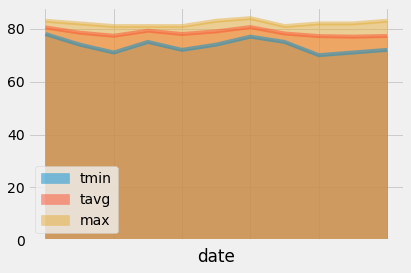

In [60]:
# Plot the daily normals as an area plot with `stacked=False
fig, ax = plt.subplots()
my_daily_normals_df.plot(kind='area', ax=ax, stacked=False) 
plt.show()
